# CME 241 Final

## Shaan Patel

### Question 1

In [1]:
from rl.distribution import Categorical
from rl.markov_process import NonTerminal
from rl.approximate_dynamic_programming import NTStateDistribution

import itertools

from rl.final.f_22_p1_skeleton import double_q_learning, q_learning, P1State, P1MDP

import matplotlib.pyplot as plt

In [29]:
startstate: NTStateDistribution = Categorical({NonTerminal(P1State("A")): 1})

mdp= P1MDP(10)

dqiter = double_q_learning(
    mdp=mdp,
    states=startstate,
    gamma=1
)

dbql = itertools.islice(dqiter, 400)

sqiter = q_learning(
    mdp=mdp,
    states=startstate,
    gamma=1
)

sql = itertools.islice(sqiter, 400)

avgdbq = []
avgsq = []

for entry in dbql:
    avgdbq.append(entry((NonTerminal(P1State("A")),"a1")))

for entry in sql:
    avgsq.append(entry((NonTerminal(P1State("A")),"a1")))


for i in range(1,100):
    iter_dbq = itertools.islice(
        double_q_learning(
            mdp=mdp,
            states=startstate,
            gamma=1
        ), 400
    )

    iter_sq = itertools.islice(
        q_learning(
            mdp=mdp,
            states=startstate,
            gamma=1
        ), 400
    )

    i = 0
    for entry in iter_dbq:
        avgdbq[i] += (1/(i+1))*(entry((NonTerminal(P1State("A")), "a1")) - avgdbq[i])

    j = 0
    for entry in iter_sq:
        avgsq[j] += (1/(j+1))*(entry((NonTerminal(P1State("A")), "a1")) - avgsq[j])

        

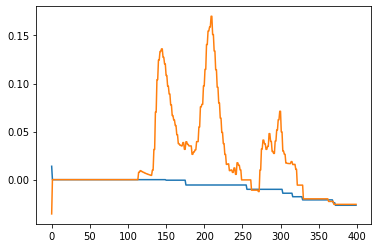

In [30]:
plt.plot(avgdbq)
plt.plot(avgsq)

### Question 4

In [164]:
from rl.markov_decision_process import FiniteMarkovDecisionProcess, TransitionStep
from rl.distribution import Categorical, Choose
from rl.function_approx import LinearFunctionApprox
from rl.policy import DeterministicPolicy, FiniteDeterministicPolicy
from rl.td import least_squares_policy_iteration
from rl.dynamic_programming import policy_iteration_result, V
from rl.chapter11.control_utils import get_vf_and_policy_from_qvf
from typing import Mapping, Tuple, Dict, Iterator, Iterable, Sequence, Callable, List
import itertools
import rl.iterate as iterate
from pprint import pprint
import matplotlib.pyplot as plt
from numpy.polynomial.laguerre import lagval
import numpy as np
from dataclasses import dataclass

In [159]:
class OneCropMDP(FiniteMarkovDecisionProcess[int,bool]):

    def __init__(
        self,
        C: int,
        z: float
    ):
        self.C: int = C
        self.z: float = z
        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> Mapping[int, Mapping[bool, Categorical[Tuple[int, int]]]]:
        d: Dict[int, Dict[bool, Categorical[Tuple[int, int]]]] = {}

        for value in range(0,self.C):
            d1: Dict[bool, Categorical[Tuple[int, int]]] = {}
            sell_act: bool = 1
            hold_act: bool = 0

            d1[sell_act] = Categorical({((0,np.log(value + 1))): 1})

            sr_probs_dict: Dict[Tuple[int,int], float] =\
                {(x, 0): (1-self.z)/(self.C + 1 - value) for x in range(value,self.C + 1)}
            
            sr_probs_dict[(0,0)] = self.z

            d1[hold_act] = Categorical(sr_probs_dict)
            d[value] = d1
        return d

    def lspi_features(
        self,
        factor1_features: int,
        factor2_features: int
    ) -> Sequence[Callable[[Tuple[NonTerminal[int], bool]], float]]:
        ret: List[Callable[[Tuple[NonTerminal[int], bool]], float]] = []
        ident1: np.ndarray = np.eye(factor1_features)
        ident2: np.ndarray = np.eye(factor2_features)
        for i in range(factor1_features):
            def factor1_ff(x: Tuple[NonTerminal[int], bool], i=i) -> float:
                return lagval(
                    float((x[0].state - 31)**2/ (x[0].state + 1)),
                    ident1[i]
                )
            ret.append(factor1_ff)
        for i in range(factor2_features):
            def factor2_ff(x: Tuple[NonTerminal[int], bool], i=i) -> float:
                return lagval(
                    float(1 - int(x[1])),
                    ident2[i]
                )
            ret.append(factor2_ff)
        return ret

    def lspi_transitions(self) -> Iterator[TransitionStep[int,bool]]:
        states_distribution: Choose[NonTerminal[int]] = Choose(self.non_terminal_states)
        while True:
            state: NonTerminal[int] = states_distribution.sample()
            action: bool = Choose([0,1]).sample()
            next_state, reward = self.step(state,action).sample()
            transition: TransitionStep[int,bool] = TransitionStep(
                state=state,
                action=action,
                next_state=next_state,
                reward=reward
            )
            yield transition

    def lspi_vf_and_policy(self) -> \
            Tuple[V[int], FiniteDeterministicPolicy[int,bool]]:
        transitions: Iterable[TransitionStep[int,bool]] = itertools.islice(
            self.lspi_transitions(),
            5000
        )
        qvf_iter: Iterator[LinearFunctionApprox[Tuple[
            NonTerminal[int], bool]]] = least_squares_policy_iteration(
                transitions=transitions,
                actions=self.actions,
                feature_functions=self.lspi_features(4,6),
                initial_target_policy=DeterministicPolicy(lambda x: 1),
                γ = 0.9,
                ε=1e-5
            )
        qvf =\
                itertools.islice(
                    qvf_iter,
                    100
                )
        qlist = []
        for entry in qvf:
            qlist.append(entry)

        main: LinearFunctionApprox[Tuple[NonTerminal[int], bool]] = qlist[99]
        return get_vf_and_policy_from_qvf(self,main)



In [160]:
C = 100
z = 0.1

crop_mdp: FiniteMarkovDecisionProcess[int, bool] =\
    OneCropMDP(C,z)

In [161]:
opt_vf_pi, opt_policy_pi = policy_iteration_result(crop_mdp,0.9)
pprint(opt_vf_pi)
pprint(opt_policy_pi)

{NonTerminal(state=0): 15.707932302667784,
 NonTerminal(state=1): 15.709503104412317,
 NonTerminal(state=2): 15.72537280336999,
 NonTerminal(state=3): 15.741435205811113,
 NonTerminal(state=4): 15.75769466246388,
 NonTerminal(state=5): 15.928890027383568,
 NonTerminal(state=6): 16.083040707210827,
 NonTerminal(state=7): 16.21657209983535,
 NonTerminal(state=8): 16.334355135491734,
 NonTerminal(state=9): 16.43971565114956,
 NonTerminal(state=10): 16.535025830953884,
 NonTerminal(state=11): 16.622037207943514,
 NonTerminal(state=12): 16.702079915617052,
 NonTerminal(state=13): 16.77618788777077,
 NonTerminal(state=14): 16.845180759257723,
 NonTerminal(state=15): 16.909719280395294,
 NonTerminal(state=16): 16.97034390221173,
 NonTerminal(state=17): 17.027502316051677,
 NonTerminal(state=18): 17.081569537321954,
 NonTerminal(state=19): 17.132862831709506,
 NonTerminal(state=20): 17.181652995878938,
 NonTerminal(state=21): 17.22817301151383,
 NonTerminal(state=22): 17.27262477408466,
 NonTe

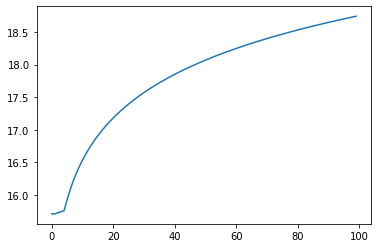

In [162]:
plotter = []
for entry in opt_vf_pi:
    plotter.append(opt_vf_pi[entry])

plt.plot(plotter)


In [158]:
lspi = crop_mdp.lspi_vf_and_policy()
pprint(lspi)

({NonTerminal(state=0): 256.1650479437399,
  NonTerminal(state=1): 249.0976953508828,
  NonTerminal(state=2): 261.4518000130006,
  NonTerminal(state=3): 268.27774396079144,
  NonTerminal(state=4): 272.30106270013,
  NonTerminal(state=5): 274.8825866895513,
  NonTerminal(state=6): 276.6513045774235,
  NonTerminal(state=7): 277.92429027959116,
  NonTerminal(state=8): 278.8754386755365,
  NonTerminal(state=9): 279.6070094478174,
  NonTerminal(state=10): 280.1826482223288,
  NonTerminal(state=11): 280.64385400081534,
  NonTerminal(state=12): 281.01875098750895,
  NonTerminal(state=13): 281.3270284295494,
  NonTerminal(state=14): 281.5828568184472,
  NonTerminal(state=15): 281.79668028532956,
  NonTerminal(state=16): 281.97635726947055,
  NonTerminal(state=17): 282.127908751264,
  NonTerminal(state=18): 282.256022280965,
  NonTerminal(state=19): 282.36439957629494,
  NonTerminal(state=20): 282.45600130424003,
  NonTerminal(state=21): 282.5332227168153,
  NonTerminal(state=22): 282.598021815

In [ ]:
@dataclass(frozen=True)
class PriceData:
    value: int
    price: float

    def get_price(self) -> float:
        return float(self.value) + self.price

class EditCropMDP(FiniteMarkovDecisionProcess[PriceData,bool]):

    def __init__(
        self,
        C: int,
        z: float,
        history: List[float]
    ):
        self.C: int = C
        self.z: float = z
        self.history: List[float] = history
        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> Mapping[PriceData, Mapping[bool, Categorical[Tuple[int, int]]]]:
        d: Dict[PriceData, Dict[bool, Categorical[Tuple[int, int]]]] = {}

        for value in range(0,self.C):
            for price in self.history:
                state: PriceData = PriceData(value,price)
                d1: Dict[bool, Categorical[Tuple[int, int]]] = {}
                sell_act: bool = 1
                hold_act: bool = 0

                d1[sell_act] = Categorical({((0,np.log(state.get_price() + 1))): 1})

                sr_probs_dict: Dict[Tuple[int,int], float] =\
                    {(x, 0): (1-self.z)/(self.C + 1 - value) for x in range(value,self.C + 1)}
            
                sr_probs_dict[(0,0)] = self.z

                d1[hold_act] = Categorical(sr_probs_dict)
                d[state] = d1
        return d